# Graphlet Correlation Analysis

Remember, in notebook *Thresholding*, I thresholded contact maps and saved so that
orca can read them.

In this notebook, I perform two actions:
1. I apply `count5` procedure in orca to extract 73 orbits for each loci in each
chromosome. After this stage, graphlets will be save with `.graphlets` extension 
in the `./data` folder.

2. I then read the graphlets and find both loci-wise distance
and graphlet-wise correlations
between the four cell lines.

By repeating steps 1 and 2 for all 23 chromosomes, I will have pairwise MIC values for all
orbits of all cell lines. I would eventually be able to have a data array of shape
``` A(23 * 73) ```, for each pair of cell lines where `A[i, j]` denotes the correlation
between the jth orbit in the ith chromosome. 


In [1]:
import numpy as np
import cv2
from utility import *
import matplotlib.pyplot as plt
from iced import normalization
from iced import filter
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. Orbit Extraction:
Once the thresholded contact maps are obtained, graphlets
and orbits can be extracted. We used the orca package in
R programming language to extract the graphlets. As a result
of graphlet extraction, For each loci in each contact map,
a signature vector of size 73 is created. Thus for each cell
line, we would have 276 signature matrices of size $|V_{ij}|\times73$,
where $|V_{ij}|$ is the number of loci involved in contact map
between chromosomes i and j
For a particular $C_{ij}$ , we denote $S_{ij}$ as its signature matrix.
Each cell $S_{ijlo}$ in $S_{ij}$ captures how many times loci $l$ in $C_{ij}$
occured as part of orbit $o$.

The following image illustrates the process of orbit extraction:

<img src='papers/manuscripts/figures/graphlet_extraction.png' width="800">

This process of graphlet extraction is repeated for all four cell 
lines that we have (MIT, ALL, RL and CALL4).

The following R-script reads edge files (`.edges`) corresponding to a chromosome under
 ```data/``` directory. It then writes the resulting orbits into
```data/*.graphlets```.

In [7]:
data_names = ["MIT", "ALL", "RL", "call4"]
root = "../data/"
file_dir_template = "../data/extracted_all_contact_%s"
file_name_template = "%s/all_in_one_500kb.npy"%(file_dir_template)
print("File Directory: \"%s\""%file_dir_template)
print("File Name Template: \"%s\""%file_name_template)

File Directory: "../data/extracted_all_contact_%s"
File Name Template: "../data/extracted_all_contact_%s/all_in_one_500kb.npy"


## Extracting orbits from thresholded files

In [3]:
#for chr1 in range(1, 24):
#    for chr2 in range(chr1, 24):
#        os.system('Rscript rscript_intra.r %s %s'%(chr1, chr2))

## Reading Already saved orbits

In [8]:
graphlets = {}
for cell in data_names:
    graphlets[cell] = {}
    count = 0
    for chr1 in range(1, 24):
        graphlets[cell][chr1] = {}
        for chr2 in range(chr1, 24):
            graphlets[cell][chr1][chr2] = readMat\
            ("%s/data/chr%02d_chr%02d_%s.graphlets"%(root, chr1, chr2, cell.lower()), delimiter=" ").astype('uint32') 
            count += 1

## Putting extracted graphlets in order
The following code block assembles all 23 orbit signature vectors of a loci into a $23 \times 73$ matrix.

In [9]:
lengths = {}
for key in data_names:
    print(key)
    lengths[key] = np.load("%s/lengths_500kb.npy"%(file_dir_template%key))            

num_loci = 100000
loci_data = {}
for cell1 in data_names:
    loci_data[cell1] = {}
    num_loci = int(np.min([np.sum(lengths[cell1][-1]), num_loci]))
    print num_loci
    for l in range(num_loci+1):
        loci_data[cell1][l] = np.zeros((24, 73), dtype='uint32')

for cell1 in data_names:
    for chr1 in range(1, 24):
        for chr2 in range(chr1, 24):
            l1 = lengths[cell1][chr1, :]
            l2 = lengths[cell1][chr2, :]
            temp = graphlets[cell1][chr1][chr2]
            if chr1 == chr2:
                for l in range(len(temp)):
                    loci_abs_num = l1[0] + l
                    loci_data[cell1][loci_abs_num][chr1] = temp[l]                
            else:
                for l in range(l1[1]):
                    loci_abs_num = l1[0] + l
                    loci_data[cell1][loci_abs_num][chr2] = temp[l]                
                for l in range(l1[1], len(temp)):
                    loci_abs_num = l2[0] + l - l1[1]
                    loci_data[cell1][loci_abs_num][chr1] = temp[l]                
                

MIT
ALL
RL
call4
6053
6053
6053
6053


In [10]:
# Test of the above procedure, the absolute difference should be 0
sum_diffs = 0
for cell_index in np.random.randint(0, len(data_names), size=3):
    cell = data_names[cell_index]
    for chr1 in np.random.choice(range(1, 24), size=3):
        for chr2 in np.random.choice(range(1, 24), size=3):
            i = np.argmin([chr1, chr2])
            if i == 1:
                c1 = chr2
                c2 = chr1
            else:
                c1 = chr1
                c2 = chr2
            for loci in np.random.choice(range(lengths[cell][c1, 1]), size=3):
                sum_diffs += int(np.sum(np.abs(loci_data[cell][loci + lengths[cell][c1, 0]][c2] - graphlets[cell][c1][c2][loci])))
print("Absolute Diference: %d"%(sum_diffs))

Absolute Diference: 0


# 2. Loci-wise Distance:
I can now read the orbit files and put them into a $N \times O$ matrix where $N$ denotes
number of loci in the chromosome and $O$ denotes the number or obitals extracted, which 
can be either 14 or 73 (depending on whether ```count4()``` or ```count5()``` are called
in the R-script above.

For a pair of cells A and B, let 
$\mathbf{S}^A_{ij}$  and $\mathbf{S}^B_{ij}$ be their
signature matrices. The *signature distance* of
contact map $\mathbf{C}_{i,j}$ between A and B is denoted
by $\mathbf{d}^{A,B}_{ij}$. $\mathbf{d}^{A,B}_{ij}$ 
is a vector of size $|V_{i,j}|$
and its elements $d^{A,B}_{i,j,l}$ are
calculated using the following formula from \cite{prvzulj2007biological}:

\begin{equation}
    d^{A,B}_{i,j,l} = 
    \frac{1}{73}\sqrt{\sum_{o=0}^{72}{t_{lo}^2}}
    \label{eq:distance_total}
\end{equation}

where elements of $t_{i,j,l,o}$ is the
distance between each
loci (row) $l$ in $\mathbf{S}^A$ and the the same loci in 
$\mathbf{S}^B$ for
orbit $o$ as is calculated as below:

\begin{equation}
    t_{lo} = w_o \times 
        \frac{log(S_{ijlo}^A+1) - log(S_{ijlo}^B+1)}
             {log(max(S_{ijlo}^A, S_{ijlo}^B) + 2)}
    \label{eq:distance_single}
\end{equation}

The following figure illustrated the process in equation \ref{eq:distance_total}:
<img src="papers/manuscripts/figures/graphlet_distance_schema.png" width="700">

Using the above two formulas, we can find loci-loci distance
between two cells, that is, for each loci in each contact 
map in cell A, we can compare it with the same loci in the
same contact map in cell B.



## Calculating Loci-wise distances:
Now we can compare contact maps with each other based on
the *signature distance* measure. For each contact map
and each pair of cells, we can perform a t-test on
the signature distances in order to see whether the
differences are 0 or not. In the following code
blocks, first we calculate the signature distances
between each pair of cells and then some visualizaitons
demonstrate how cells are different.

In [11]:
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
cells = ['mit', 'all', 'rl', 'call4']
graphlets = {}
for cell in cells:
    graphlets[cell] = {}
    for chr1 in range(1, 24):
        graphlets[cell][chr1] = {}
        for chr2 in range(chr1, 24):
            graphlets[cell][chr1][chr2] = readMat\
            ("%s/data/chr%02d_chr%02d_%s.graphlets"%\
             (root, chr1, chr2, cell), delimiter=" ").astype('uint32') 
        
distances = {}
actual_distances = {}
for cell in cells:
    distances[cell] = {}
    actual_distances[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        distances[cell1][cell2] = np.zeros((count, 4))
        distances[cell2][cell1] = distances[cell1][cell2]
        actual_distances[cell1][cell2] = [None] * (count)
        actual_distances[cell2][cell1] = actual_distances[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        print(cell1, cell2)
        for chr1 in range(1, 24):
            for chr2 in range(chr1, 24):
                count = chr2count[(chr1, chr2)]
                temp =  row_wise_graphlet_distance(graphlets[cell1][chr1][chr2]\
                                , graphlets[cell2][chr1][chr2])
                actual_distances[cell1][cell2][count] = temp
                distances[cell1][cell2][count, 0] = np.nanmean(temp)
                distances[cell1][cell2][count, 1] = np.nanstd(temp, ddof=1)
                t0, pvalue = t_test(temp, one_sided=True)
                distances[cell1][cell2][count, 2] = t0
                distances[cell1][cell2][count, 3] = pvalue

('mit', 'rl')
('all', 'mit')
('all', 'rl')
('all', 'call4')
('call4', 'mit')
('call4', 'rl')


In [12]:
sameIndices = []
for chr1 in range(1, 24):
    sameIndices.append(chr2count[(chr1, chr1)])
print("Same indices: %s\n"%sameIndices)
differentIndices = []
for chr1 in range(1, 24):
    for chr2 in range(chr1+1, 24):
        differentIndices.append(chr2count[(chr1, chr2)])
print("Different indices: %s"%differentIndices)

Same indices: [0, 23, 45, 66, 86, 105, 123, 140, 156, 171, 185, 198, 210, 221, 231, 240, 248, 255, 261, 266, 270, 273, 275]

Different indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203,

### All pair-wise signature distances
The following is a graph comparing contact maps in terms of average loci-loci distances. For each pair of cells
$A$ and $B$, $\bar{d}^{\hspace{.2cm}A,B}_{ij}$ is calculated. As can be seen in the third graph, which also shows
errors of half standard deviation, we can see that almost none
of the graphlet distances are not within half a standard
deviation of zero.

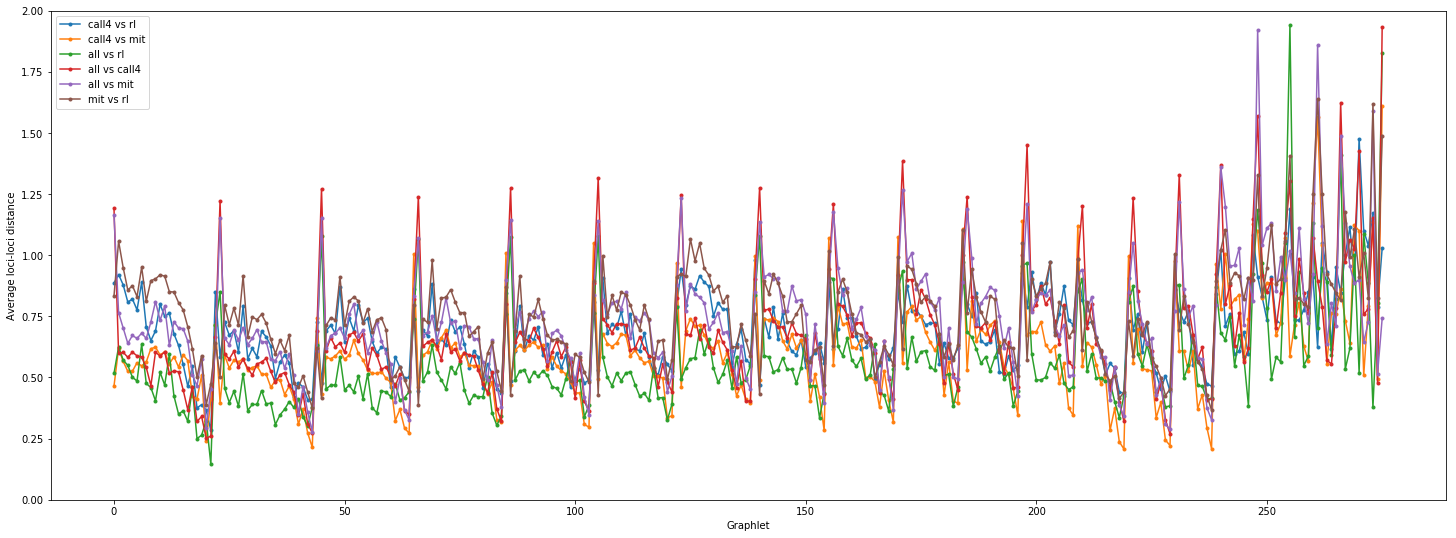

In [13]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    for cell2 in distances[cell1]:
        if cell1 >= cell2:
            continue
        y = distances[cell1][cell2][:, 0]
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])
        ax.set_ylabel('Average loci-loci distance')
        ax.set_xlabel('Graphlet')

plt.legend()
plt.show()

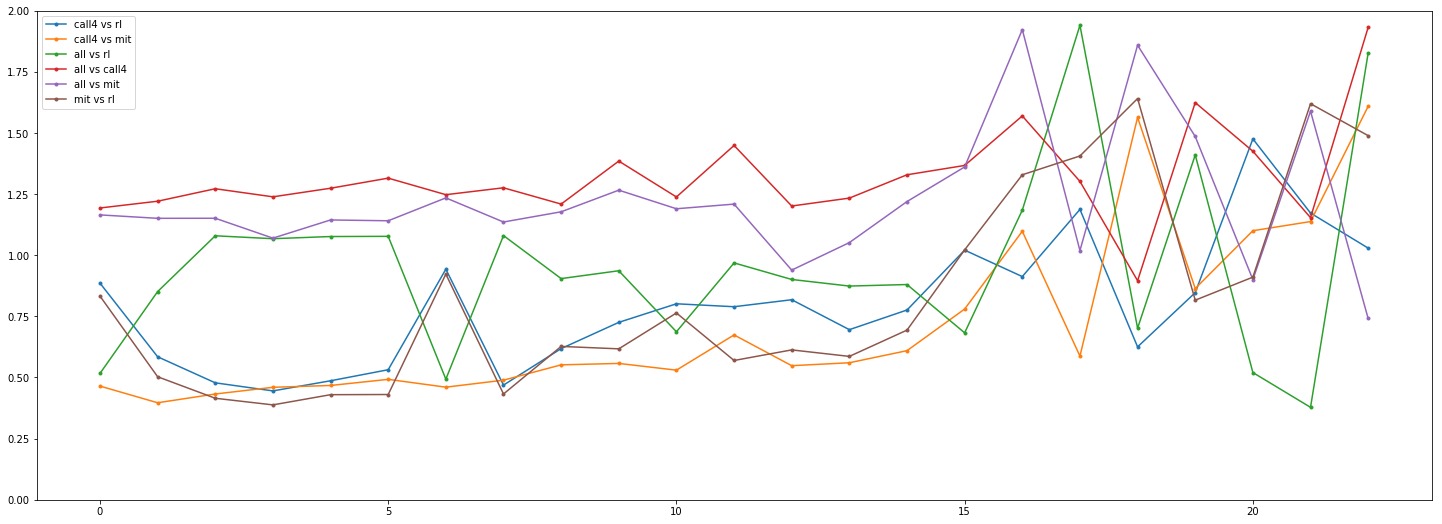

In [14]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    for cell2 in distances[cell1]:
        if cell1 >= cell2:
            continue
        y = distances[cell1][cell2][sameIndices, 0]
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])

plt.legend()
plt.show()

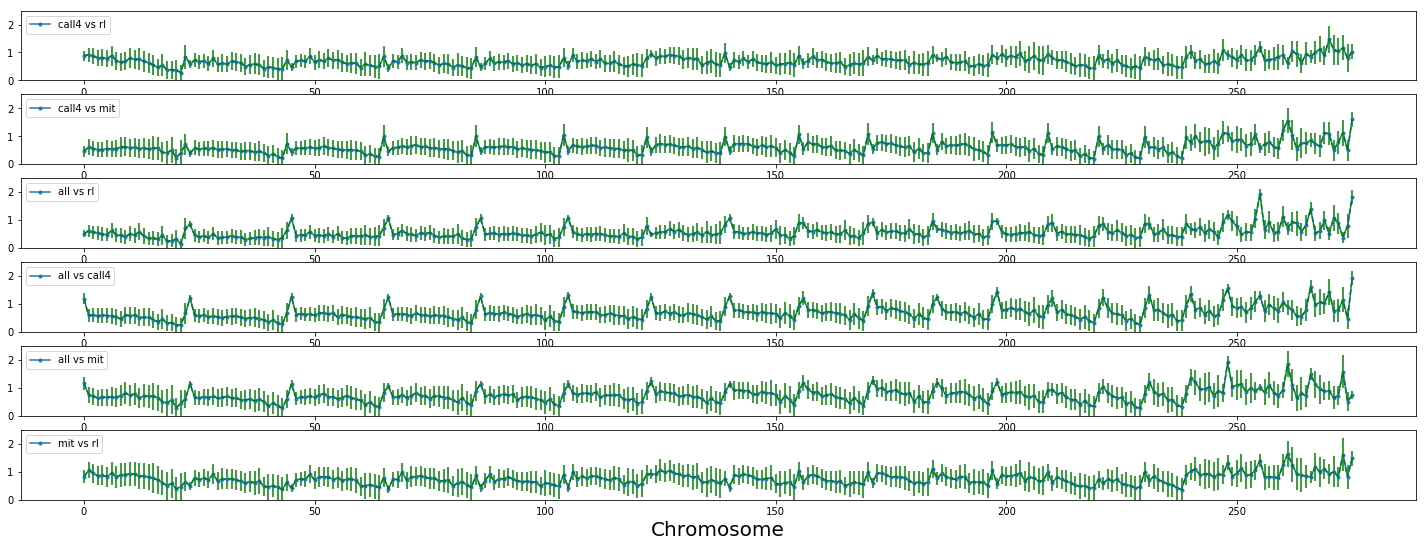

In [15]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
count = 1
for cell1 in distances:
    for cell in distances[cell1]:
        if cell <= cell1:
            continue
        ax = plt.subplot(6, 1, count)
        count +=1
        y = distances[cell1][cell][:, 0]
        y_error = .5 * distances[cell1][cell][:,1]
        line2, = ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0., 2.5])
        ax.legend(handles=[line2], loc=2)
ax.set_xlabel("Chromosome", fontsize=20)
plt.show()

### MIT vs Cancer average signature distance

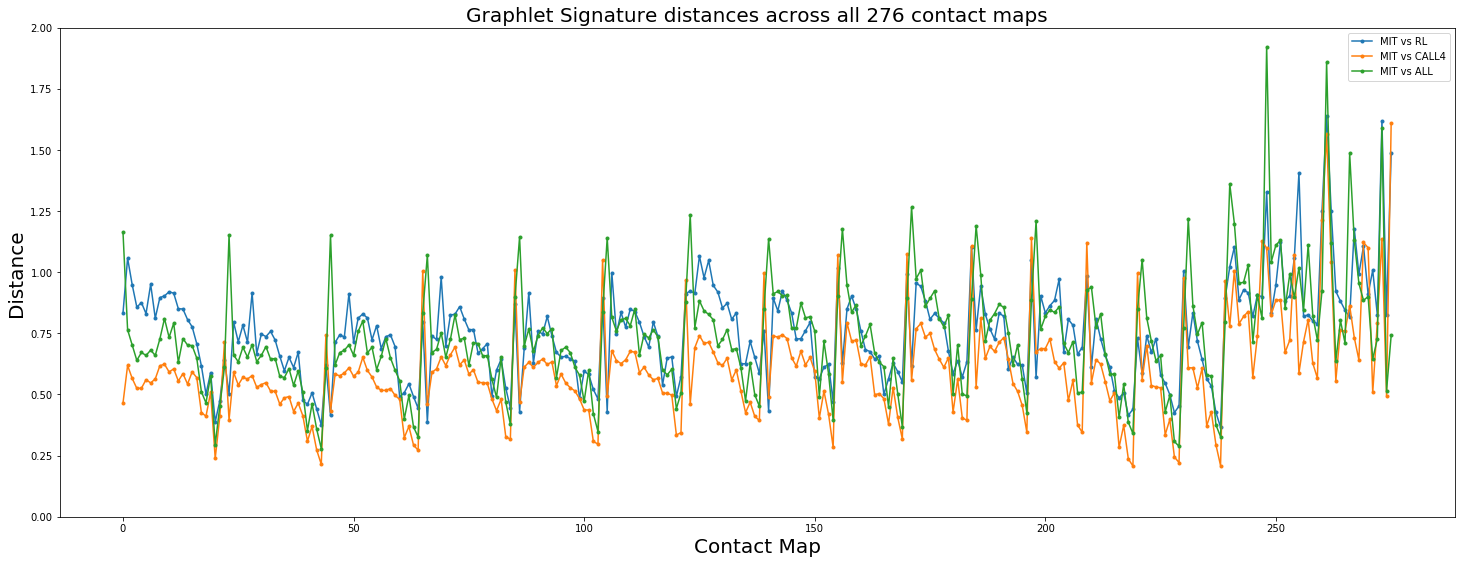

In [123]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
ax.set_title("Graphlet Signature distances across all 276 contact maps"
            , fontsize=20)
ax.set_xlabel("Contact Map", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)
for cell in distances['mit']:
    y = distances['mit'][cell][:, 0]
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 2])

plt.legend()
plt.show()

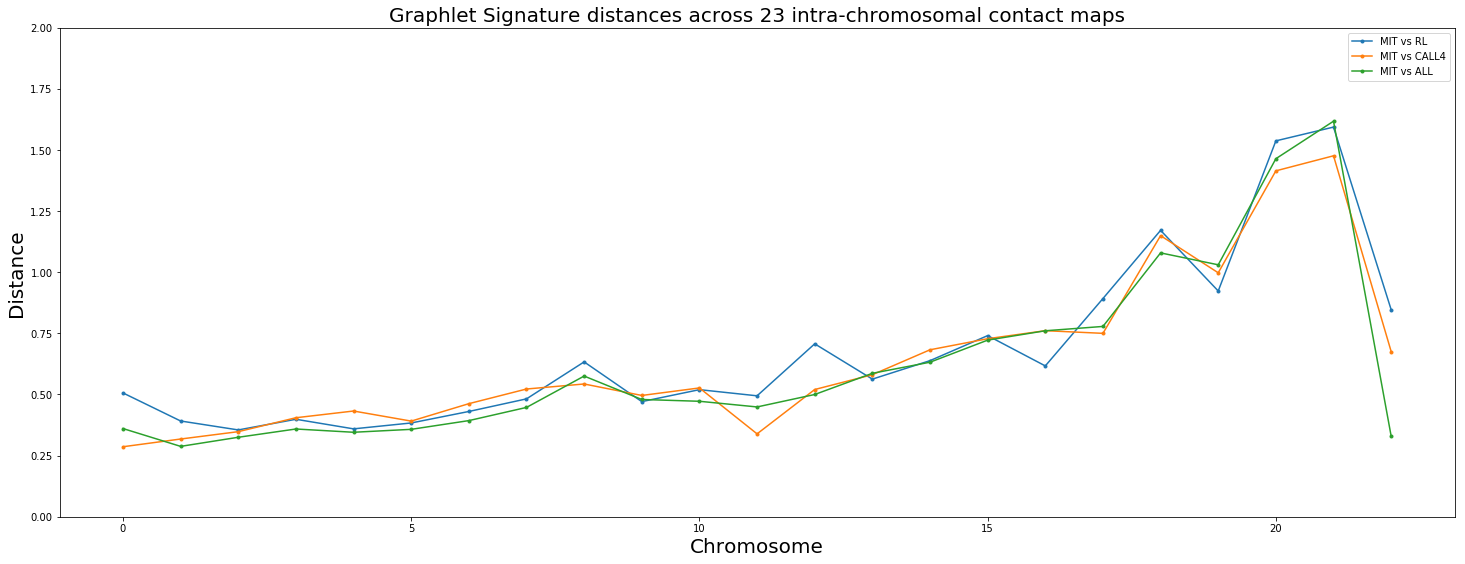

In [119]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
ax.set_title("Graphlet Signature distances across 23 intra-chromosomal contact maps"
            , fontsize=20)
ax.set_xlabel("Chromosome", fontsize=20)
ax.set_ylabel("Distance", fontsize=20)
for cell in distances['mit']:
    y = distances['mit'][cell][sameIndices, 0]
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 2])

plt.legend()
plt.show()

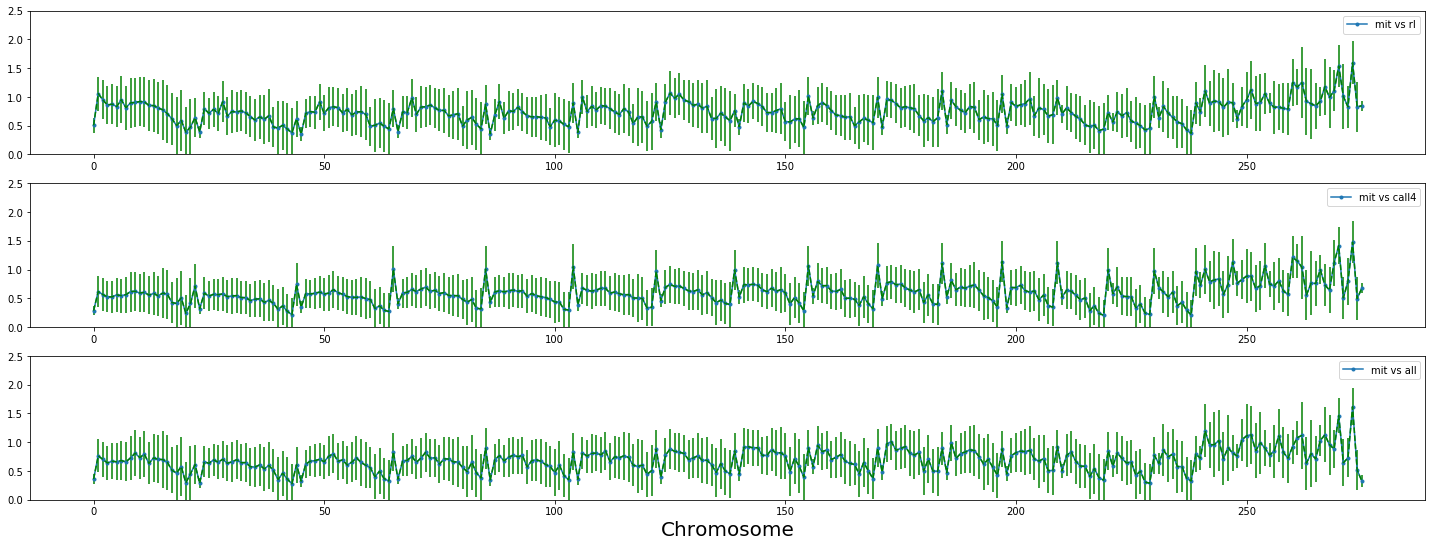

In [102]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
count = 1
for cell in distances['mit']:
    ax = plt.subplot(3, 1, count)
    count +=1
    y = distances['mit'][cell][:, 0]
    y_error = .5 * distances['mit'][cell][:,1]
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_ylim([0., 2.5])
    ax.legend()
ax.set_xlabel("Chromosome", fontsize=20)
plt.show()

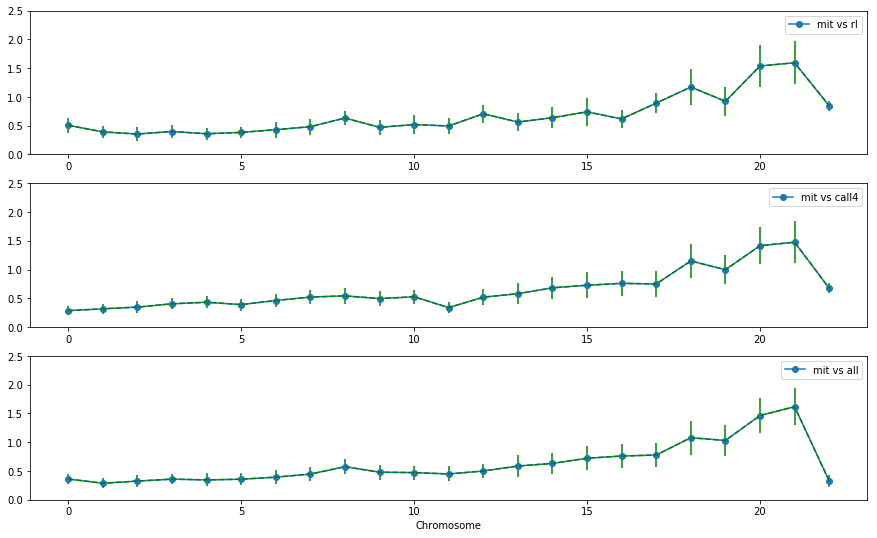

In [45]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell in distances['mit']:
    ax = plt.subplot(3, 1, count)
    count +=1
    y = distances['mit'][cell][sameIndices, 0]
    y_error = .5 * distances['mit'][cell][sameIndices,1]
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_ylim([0., 2.5])
    ax.legend()
ax.set(xlabel="Chromosome")
plt.show()

### Cancer vs Cancer average distance vector

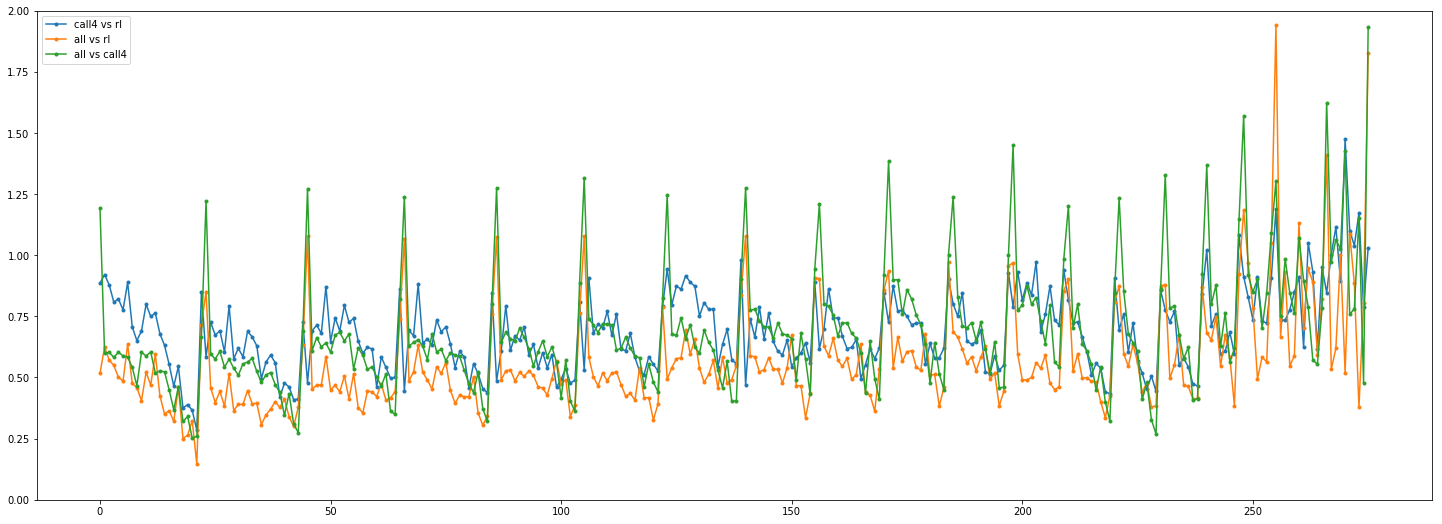

In [124]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(distances['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    if cell1 == 'mit':
        continue
    for cell2 in distances[cell1]:
        if cell2 == 'mit' or cell1 >= cell2:
            continue
        y = distances[cell1][cell2][:, 0]
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])

plt.legend()
plt.show()

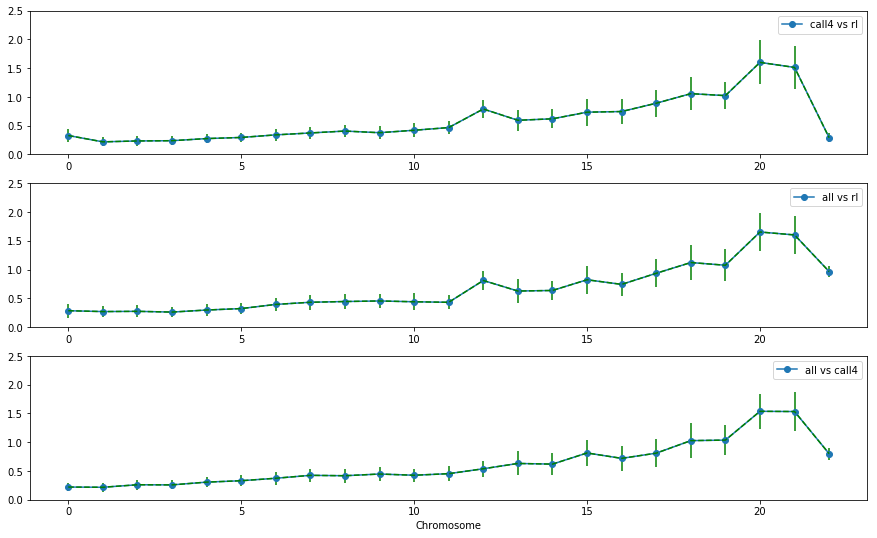

In [47]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell1 in distances:
    if cell1 == 'mit':
        continue
    for cell2 in distances[cell1]:
        if cell2 < cell1 or cell2 == 'mit':
            continue
        ax = plt.subplot(3, 1, count)
        count +=1
        y = distances[cell1][cell2][sameIndices, 0]
        y_error = .5*distances[cell1][cell2][sameIndices,1]
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0., 2.5])
        ax.legend()
ax.set(xlabel="Chromosome")
plt.show()

## Statistical Analysis
We performed a pairwise t-test (with $\alpha = 0.5$ 
between each pair of cell distances (including a comparison with 0) for 
each graphlet. The results are calculated in the following block. As can be viewed, All pairwise distances
are significantly larger than 0 

In [302]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = actual_distances[cell1][cell2][cmi]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        zero_array = np.zeros_like(cm)               
        a.append(zero_array)
        labels.append("zero")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1        zero  <  call4-mit  <     all-rl  <     mit-rl  <   call4-rl  <    all-mit  =  all-call4
 1  2        zero  <     all-rl  =  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  3        zero  <     all-rl  =  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  4        zero  <     all-rl  =  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  5        zero  <     all-rl  =  call4-mit  <  all-call4  <    all-mit  <   call4-rl  <     mit-rl
 1  6        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  <   call4-rl  <     mit-rl
 1  7        zero  <  all-call4  =  call4-mit  <    all-mit  =     all-rl  <   call4-rl  <     mit-rl
 1  8        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  =   call4-rl  <     mit-rl
 1  9        zero  <     all-rl  =  all-call4  <  call4-mit  =   call4-rl  <    all-mit  <     mit-rl
 1 10        zero  <     all-rl  <  all-call4  =  call4-mit  <   call4-rl  <    al

 4 23        zero  <     all-rl  =  all-call4  =     mit-rl  =    all-mit  =   call4-rl  <  call4-mit
 5  5        zero  <     mit-rl  =  call4-mit  =   call4-rl  <     all-rl  <    all-mit  <  all-call4
 5  6        zero  <     all-rl  <  all-call4  =  call4-mit  =     mit-rl  =    all-mit  =   call4-rl
 5  7        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  =   call4-rl  <     mit-rl
 5  8        zero  <     all-rl  <     mit-rl  =  all-call4  =  call4-mit  =    all-mit  =   call4-rl
 5  9        zero  <     all-rl  <  all-call4  =  call4-mit  =   call4-rl  <     mit-rl  =    all-mit
 5 10        zero  <     all-rl  <  call4-mit  =   call4-rl  <     mit-rl  =    all-mit  =  all-call4
 5 11        zero  <     all-rl  <  all-call4  =  call4-mit  <    all-mit  =   call4-rl  <     mit-rl
 5 12        zero  <     all-rl  <  all-call4  =  call4-mit  =   call4-rl  <     mit-rl  =    all-mit
 5 13        zero  <     all-rl  =    all-mit  =  all-call4  =  call4-mit  <     m

10 12        zero  <     all-rl  <  call4-mit  =   call4-rl  <     mit-rl  =  all-call4  <    all-mit
10 13        zero  <     all-rl  <  all-call4  =  call4-mit  =   call4-rl  <     mit-rl  =    all-mit
10 14        zero  <     all-rl  <  call4-mit  =     mit-rl  =  all-call4  =    all-mit  =   call4-rl
10 15        zero  <     all-rl  =  call4-mit  =   call4-rl  <     mit-rl  =  all-call4  <    all-mit
10 16        zero  <     all-rl  <  call4-mit  <  all-call4  =     mit-rl  =    all-mit  =   call4-rl
10 17        zero  <     all-rl  <  call4-mit  <     mit-rl  =    all-mit  =  all-call4  =   call4-rl
10 18        zero  <   call4-rl  <     mit-rl  =     all-rl  =  all-call4  =  call4-mit  <    all-mit
10 19        zero  <     all-rl  =    all-mit  =  all-call4  =     mit-rl  =  call4-mit  =   call4-rl
10 20        zero  <     all-rl  =  call4-mit  =     mit-rl  =  all-call4  =    all-mit  =   call4-rl
10 21        zero  <     all-rl  =  call4-mit  <    all-mit  =     mit-rl  =  all-

# 3. Orbit-wise Correlation
<img src="papers/manuscripts/figures/graphlet_correlation_schema.png">

In [129]:
cells = ['mit', 'all', 'rl', 'call4']
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
correlations = {}
for cell in cells:
    correlations[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        correlations[cell1][cell2] = np.zeros((count, 73))
        correlations[cell2][cell1] = correlations[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        print(cell1, cell2)
        count = 0 
        for chr1 in range(1, 24):
            for chr2 in range(chr1, 24):
                correlations[cell1][cell2][count, :] =  row_wise_pearson(graphlets[cell1][chr1][chr2].T\
                                , graphlets[cell2][chr1][chr2].T)
                count+=1

('mit', 'rl')
('all', 'mit')
('all', 'rl')
('all', 'call4')
('call4', 'mit')
('call4', 'rl')


In [317]:
indices = np.array([ 0,  1,  2,  4,  5,  6,  7,  8, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        35, 36, 37, 38, 49, 50]) 

### MIT vs Cancer Graphlet Orbit Correlaiton Comparison

(276, 73)


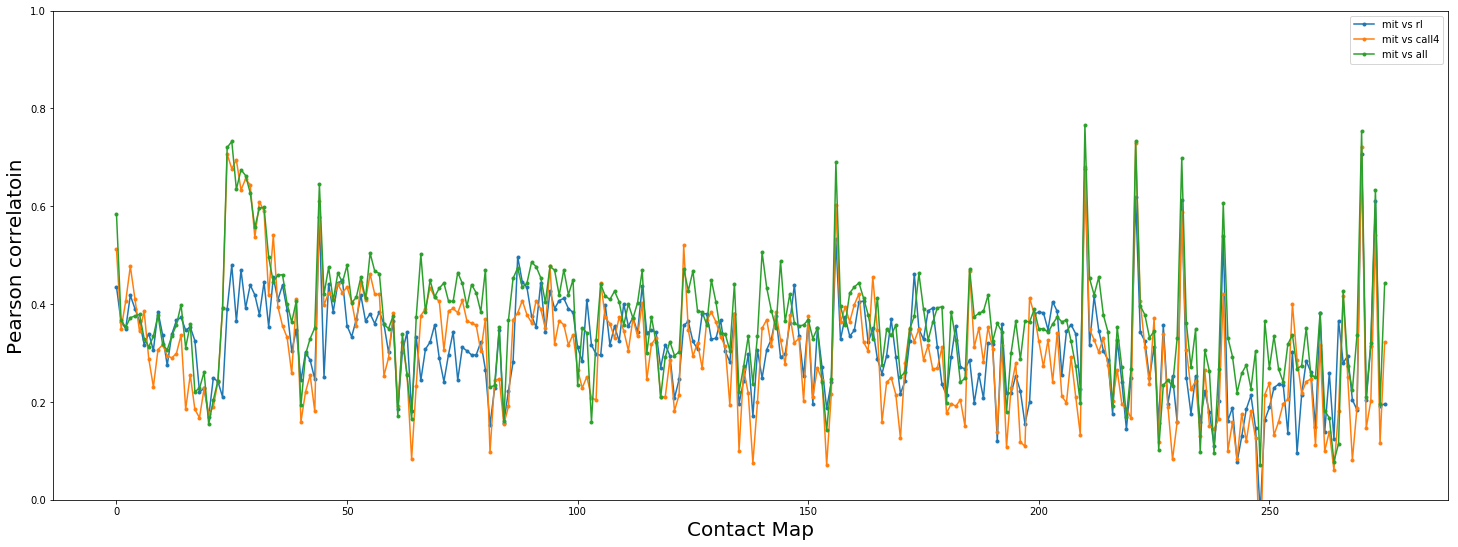

In [137]:
print(correlations['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(correlations['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.nanmean(correlations['mit'][cell][:,indices], axis=1)
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.set_ylim([0, 1])
    ax.set_xlabel("Contact Map", fontsize=20)
    ax.set_ylabel("Pearson correlatoin", fontsize=20)
plt.legend()
plt.show()

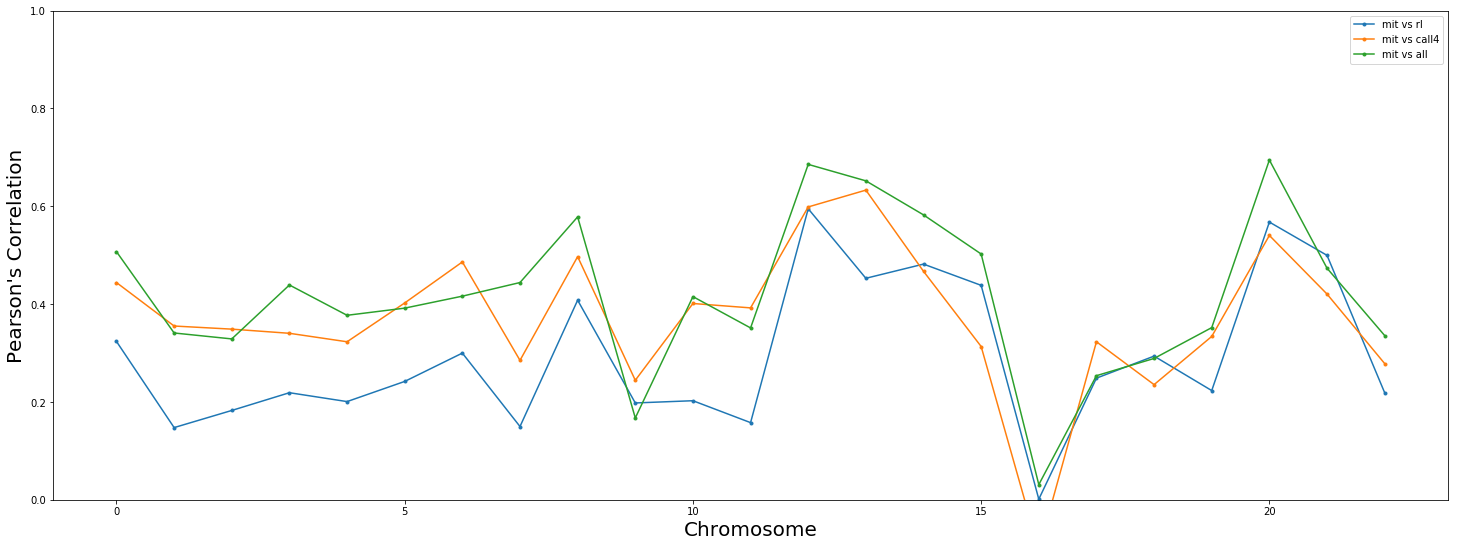

In [134]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.nanmean(correlations['mit'][cell][sameIndices,:], axis=1)
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.set(ylim=[0, 1])
    ax.set_xlabel('Chromosome', fontsize=20)
    ax.set_ylabel('Pearson\'s Correlation', fontsize=20)
plt.legend()
plt.show()

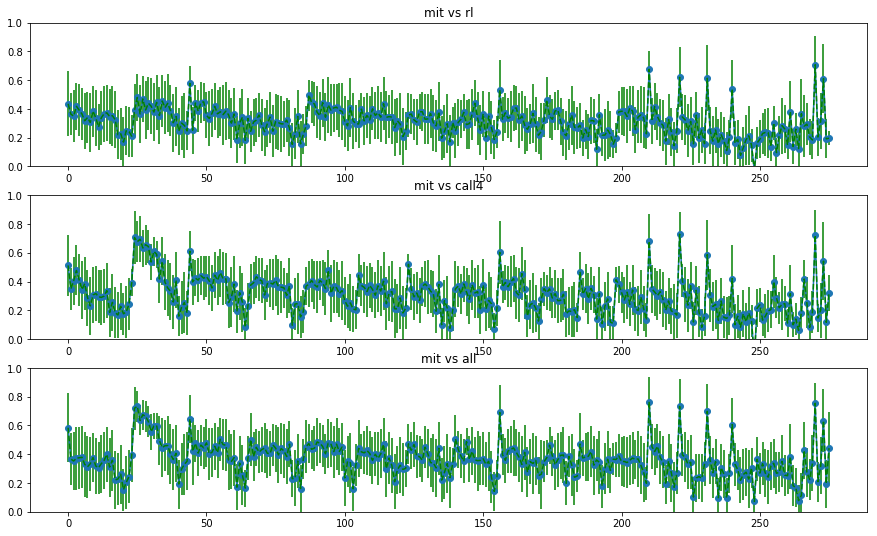

In [135]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(correlations['mit']['rl']))
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    temp = correlations['mit'][cell][:,indices]
    y = np.nanmean(temp, axis=1)
    y_error = np.nanstd(temp, axis=1)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])
plt.show()

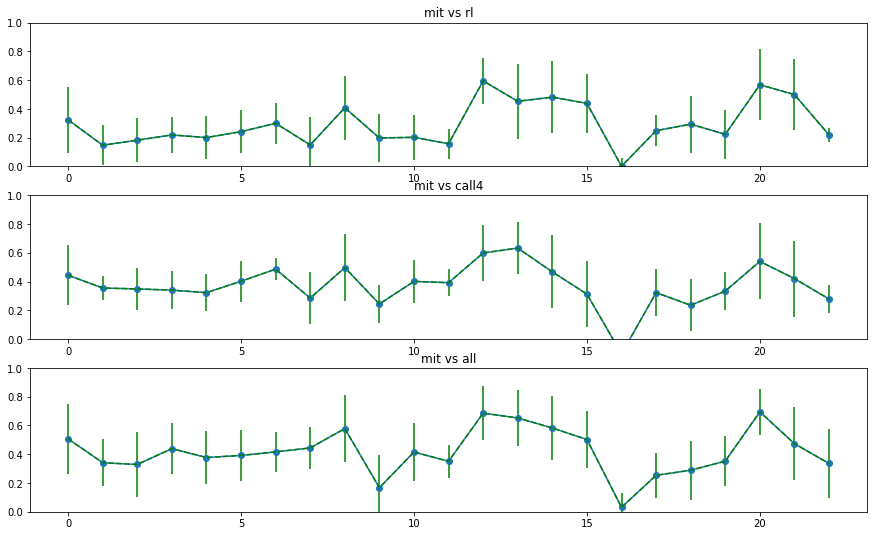

In [138]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    temp = correlations['mit'][cell][sameIndices, :]
    y = np.nanmean(temp, axis=1)
    y_error = np.nanstd(temp, axis=1)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])
plt.show()

## Statistical Analysis

In [307]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = correlations[cell1][cell2][cmi]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        zero_array = np.zeros_like(cm)               
        a.append(zero_array)
        labels.append("zero")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1        zero  <     mit-rl  <  call4-mit  <    all-mit  =     all-rl  <   call4-rl  <  all-call4
 1  2        zero  <     mit-rl  =    all-mit  =  call4-mit  =   call4-rl  <     all-rl  =  all-call4
 1  3        zero  <     mit-rl  =    all-mit  <  call4-mit  <     all-rl  =  all-call4  =   call4-rl
 1  4        zero  <    all-mit  <     mit-rl  <     all-rl  =  all-call4  =  call4-mit  <   call4-rl
 1  5        zero  <     mit-rl  =    all-mit  <  call4-mit  <     all-rl  <  all-call4  =   call4-rl
 1  6        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  =   call4-rl
 1  7        zero  <     mit-rl  =    all-mit  <  call4-mit  <     all-rl  <  all-call4  =   call4-rl
 1  8        zero  <    all-mit  =     mit-rl  =  call4-mit  <     all-rl  <  all-call4  =   call4-rl
 1  9        zero  <  call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  =   call4-rl
 1 10        zero  <  call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     a

 4 22        zero  <     mit-rl  =    all-mit  =  call4-mit  <  all-call4  <     all-rl  =   call4-rl
 4 23        zero  <  all-call4  =  call4-mit  <     mit-rl  =     all-rl  <    all-mit  =   call4-rl
 5  5        zero  <     mit-rl  <  call4-mit  <     all-rl  <    all-mit  <  all-call4  <   call4-rl
 5  6        zero  <  call4-mit  <    all-mit  <     mit-rl  <     all-rl  =  all-call4  <   call4-rl
 5  7        zero  <  call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  <   call4-rl
 5  8        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  <   call4-rl
 5  9        zero  <     mit-rl  =  call4-mit  <     all-rl  <    all-mit  <  all-call4  =   call4-rl
 5 10        zero  <     mit-rl  <  call4-mit  <    all-mit  =     all-rl  =  all-call4  <   call4-rl
 5 11        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  <   call4-rl
 5 12        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  <  all-

 9 23        zero  <  all-call4  =  call4-mit  <     mit-rl  =     all-rl  <    all-mit  =   call4-rl
10 10        zero  <    all-mit  <     mit-rl  <  call4-mit  <  all-call4  <     all-rl  <   call4-rl
10 11        zero  <     mit-rl  =    all-mit  =  call4-mit  <     all-rl  =  all-call4  <   call4-rl
10 12        zero  <  call4-mit  <     mit-rl  =    all-mit  =     all-rl  =  all-call4  =   call4-rl
10 13        zero  <     mit-rl  =     all-rl  =  call4-mit  =   call4-rl  <    all-mit  =  all-call4
10 14        zero  <  call4-mit  <     mit-rl  <    all-mit  <     all-rl  =  all-call4  =   call4-rl
10 15        zero  <    all-mit  =  call4-mit  <     mit-rl  <   call4-rl  <     all-rl  =  all-call4
10 16        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  =  all-call4  =   call4-rl
10 17        zero  <  call4-mit  <     mit-rl  <    all-mit  <     all-rl  =  all-call4  =   call4-rl
10 18        zero  <     mit-rl  <  call4-mit  <    all-mit  =     all-rl  =  all-

18 19        zero  <     mit-rl  <    all-mit  =     all-rl  =  call4-mit  =   call4-rl  <  all-call4
18 20        zero  <     mit-rl  =  call4-mit  <    all-mit  <   call4-rl  <  all-call4  <     all-rl
18 21        zero  <  call4-mit  <     mit-rl  =   call4-rl  <    all-mit  =  all-call4  <     all-rl
18 22        zero  <  all-call4  =   call4-rl  <     mit-rl  =    all-mit  =  call4-mit  <     all-rl
18 23        zero  <     all-rl  =     mit-rl  =  all-call4  =  call4-mit  =    all-mit  =   call4-rl
19 19        zero  <  call4-mit  <     mit-rl  =    all-mit  <     all-rl  <  all-call4  <   call4-rl
19 20        zero  <  call4-mit  <     mit-rl  <    all-mit  <  all-call4  <     all-rl  <   call4-rl
19 21        zero  <    all-mit  =  call4-mit  <     mit-rl  =     all-rl  =  all-call4  <   call4-rl
19 22        zero  <    all-mit  =  call4-mit  <     mit-rl  <     all-rl  =  all-call4  <   call4-rl
19 23        zero  <    all-mit  <     all-rl  =  call4-mit  <     mit-rl  =  all-

In [310]:
for o in range(73):
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = correlations[cell1][cell2][:, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    zero_array = np.zeros_like(cm)               
    a.append(zero_array)
    labels.append("zero")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  <   call4-rl
 1        zero  <     mit-rl  =  call4-mit  <    all-mit  <  all-call4  <     all-rl  =   call4-rl
 2        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  <   call4-rl
 3        zero  <     mit-rl  <    all-mit  =     all-rl  =  call4-mit  <  all-call4  =   call4-rl
 4        zero  <  call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl
 5        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  <   call4-rl
 6        zero  <  call4-mit  <     mit-rl  <    all-mit  <  all-call4  =   call4-rl  <     all-rl
 7        zero  <     mit-rl  =  call4-mit  <    all-mit  <     all-rl  <  all-call4  <   call4-rl
 8        zero  <     mit-rl  =  call4-mit  <    all-mit  <  all-call4  <     all-rl  =   call4-rl
 9        zero  <     mit-rl  <     all-rl  =  call4-mit  =  all-call4  =    all-mit  =   call4-rl
10        

### MIT vs Cancer Orbit Distribution Comparison

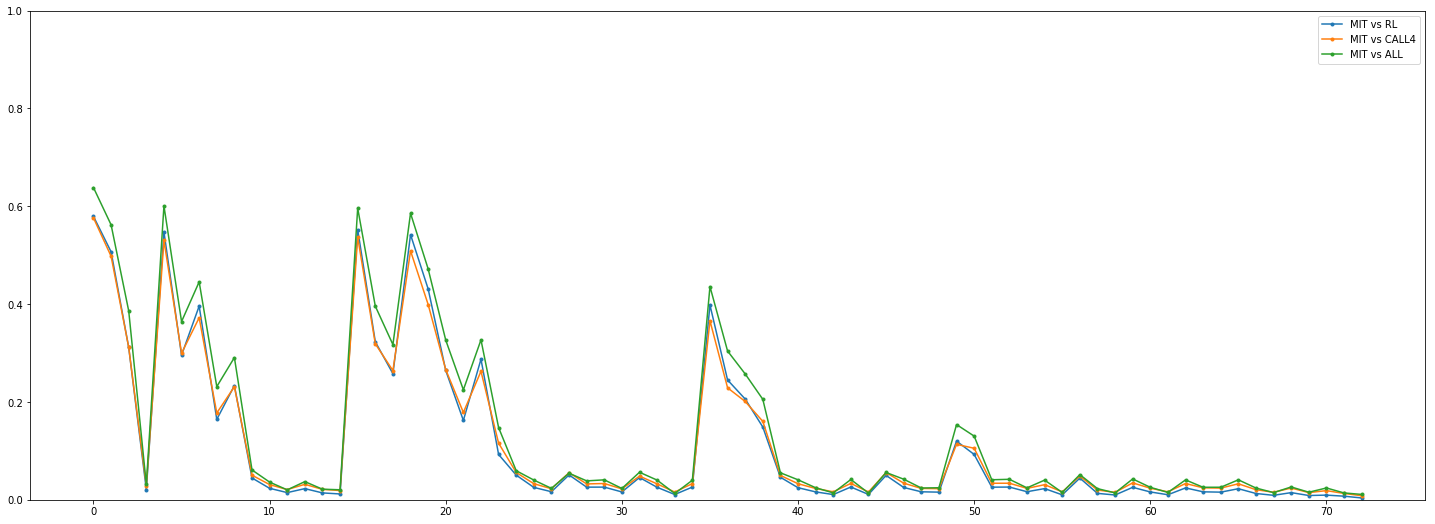

In [139]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(73)
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.mean(correlations['mit'][cell][:,:], axis=0)
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 1])
    
plt.legend()
plt.show()

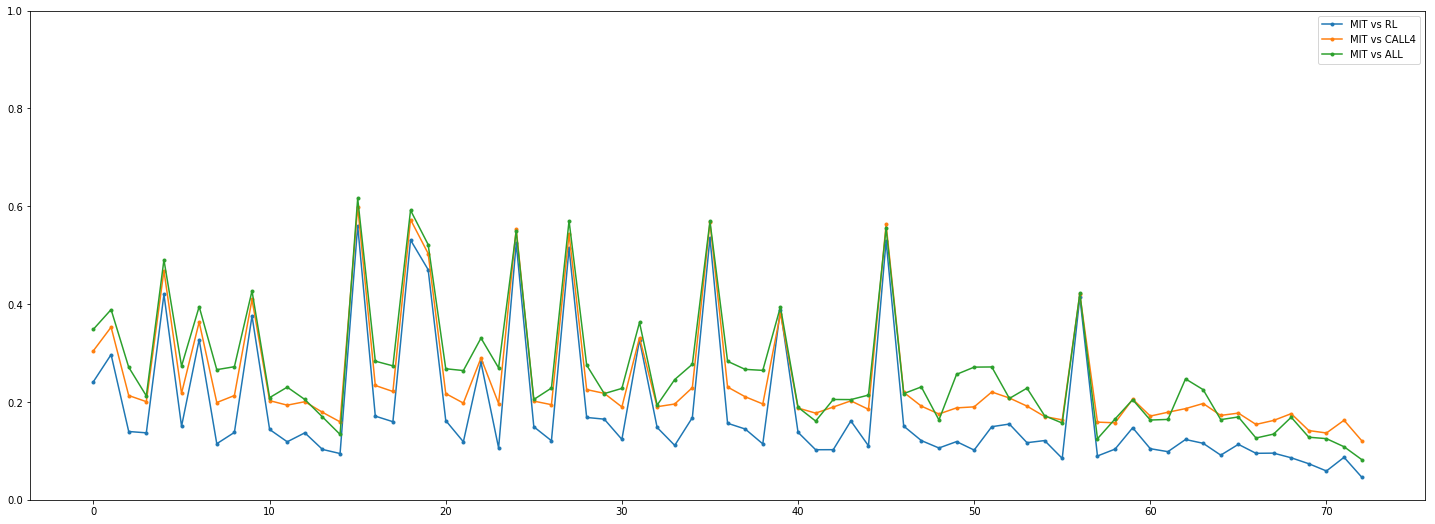

In [144]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(73)
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.mean(correlations['mit'][cell][sameIndices,:], axis=0)
    ax.plot(x, y, marker=".", label="MIT vs %s"%cell.upper())
    ax.set_ylim([0, 1])
    
plt.legend()
plt.show()

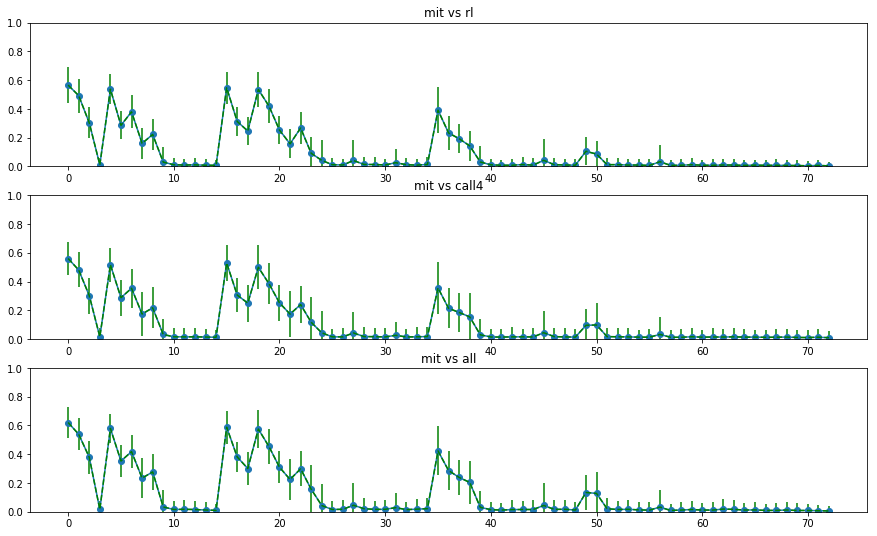

In [79]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    y = np.mean(correlations['mit'][cell][1:,:], axis=0)
    y_error = np.std(correlations['mit'][cell][1:,:], axis=0)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])

plt.show()

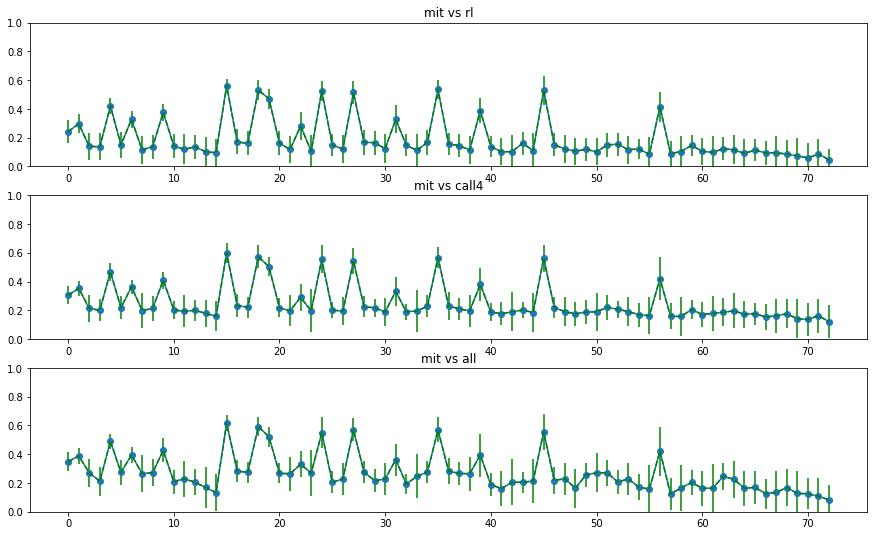

In [80]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(73)
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    y = np.mean(correlations['mit'][cell][sameIndices,:], axis=0)
    y_error = np.std(correlations['mit'][cell][sameIndices,:], axis=0)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])

plt.show()

# Cancer vs Cancer contact map orbit correlation comparison

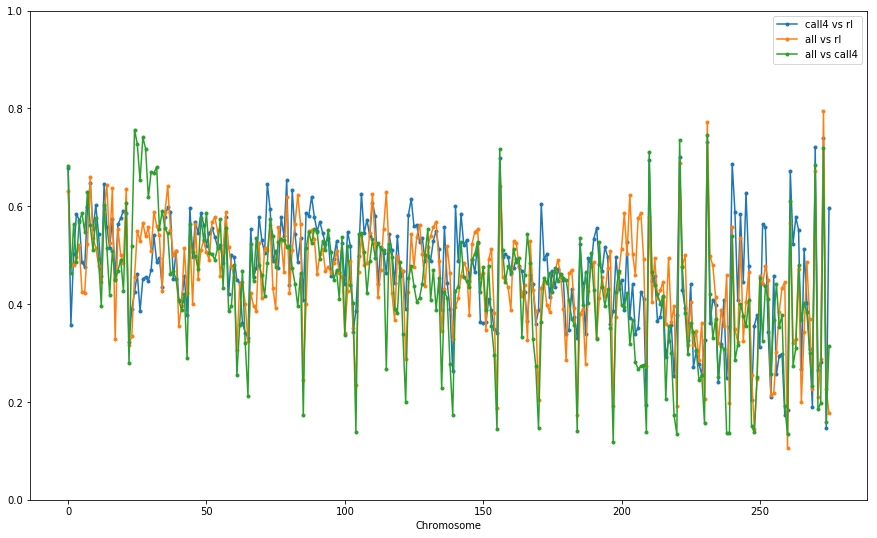

In [140]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(correlations['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.nanmean(correlations[cell1][cell2][:,indices], axis=1)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

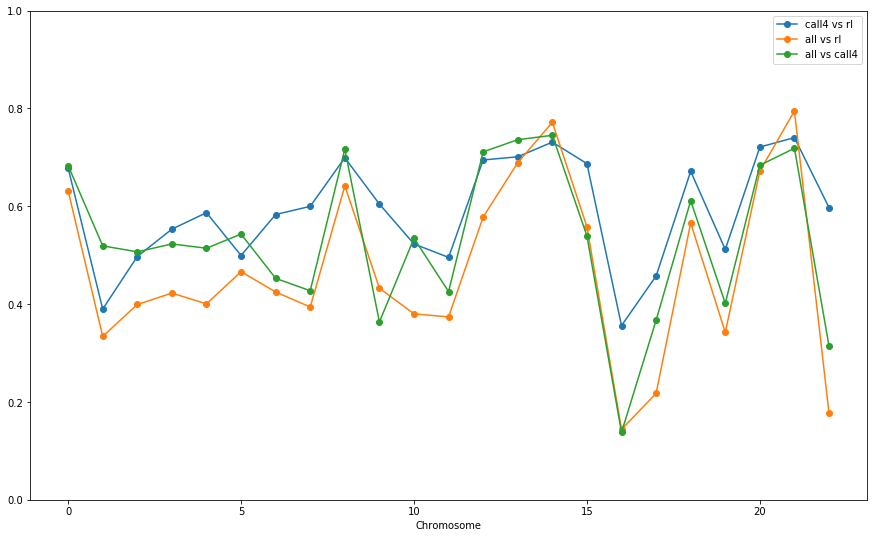

In [141]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.nanmean(correlations[cell1][cell2][sameIndices, :][:, indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

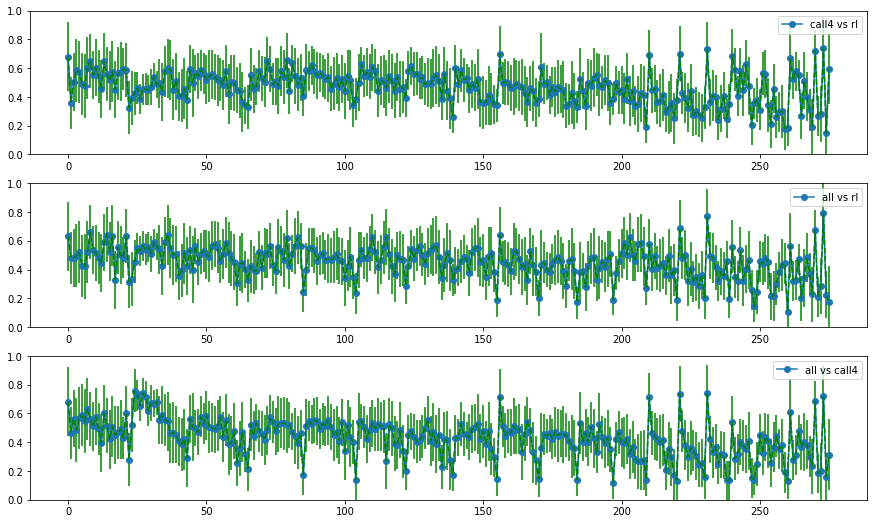

In [142]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(correlations['mit']['rl']))
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.nanmean(correlations[cell1][cell2][:,indices], axis=1)
        y_error = np.nanstd(correlations['mit'][cell][:,indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.legend()
        ax.set_ylim([0, 1])
plt.show()

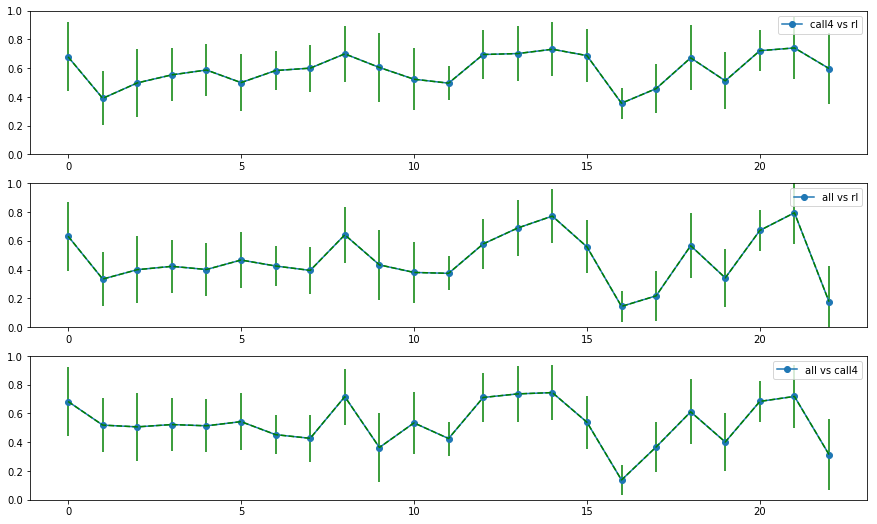

In [143]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.nanmean(correlations[cell1][cell2][sameIndices, :][:,indices], axis=1)
        y_error = np.nanstd(correlations['mit'][cell][sameIndices, :][:,indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.legend()
        ax.set_ylim([0, 1])
plt.show()

### Cancer vs Cancer Orbit correlation

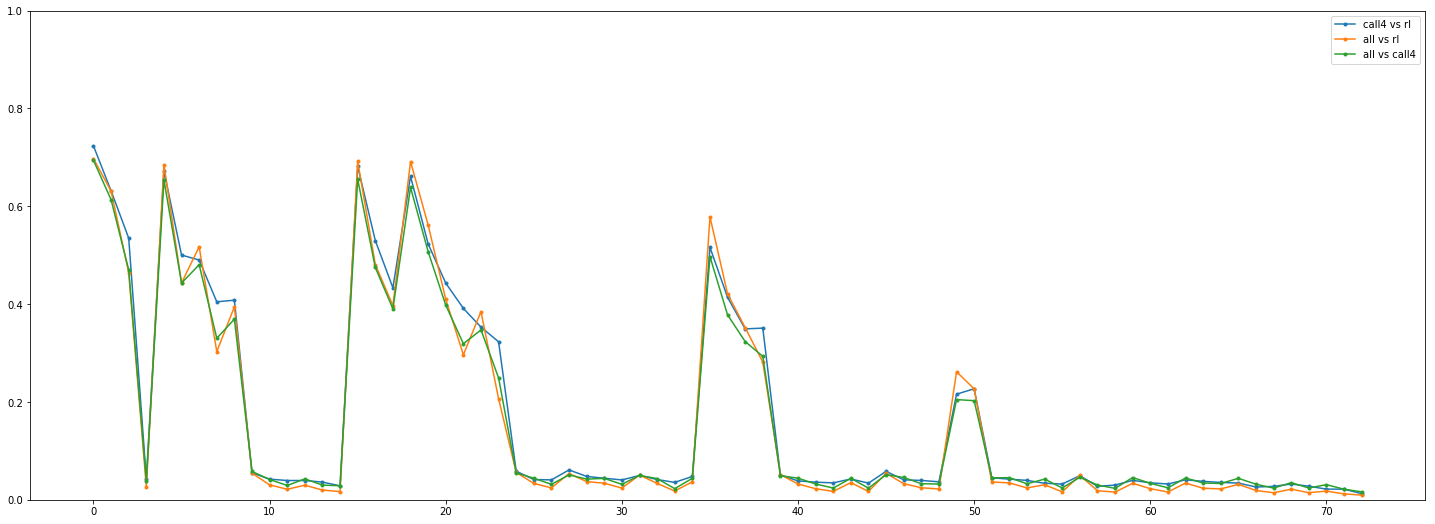

In [144]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.mean(correlations[cell1][cell2][:,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

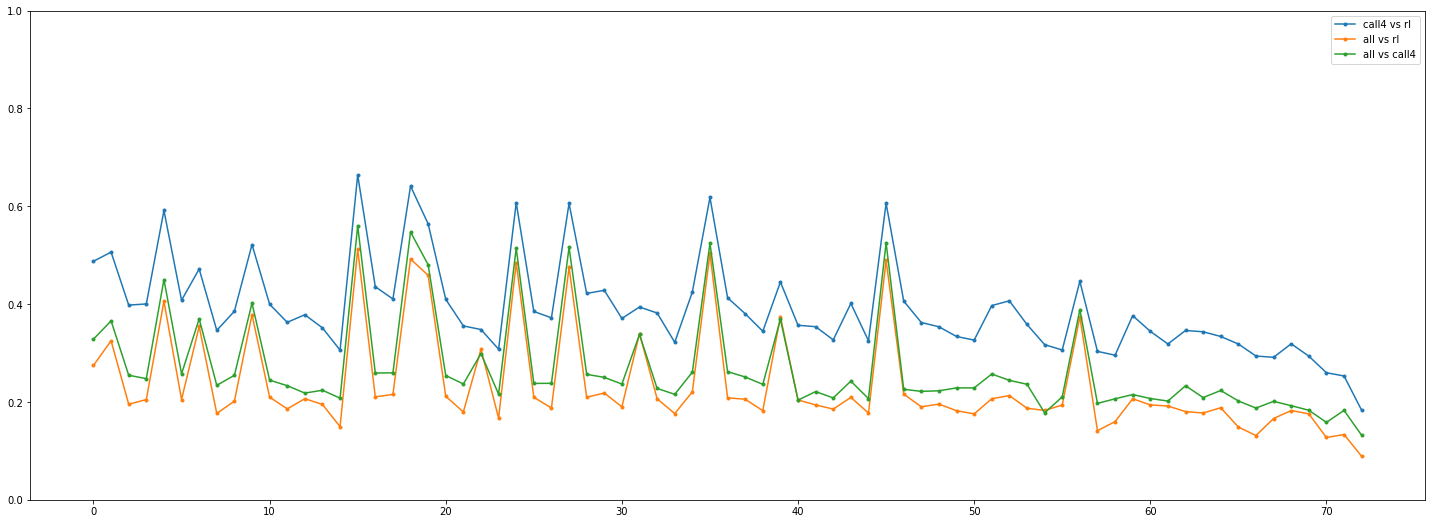

In [140]:
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.mean(correlations[cell1][cell2][sameIndices,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

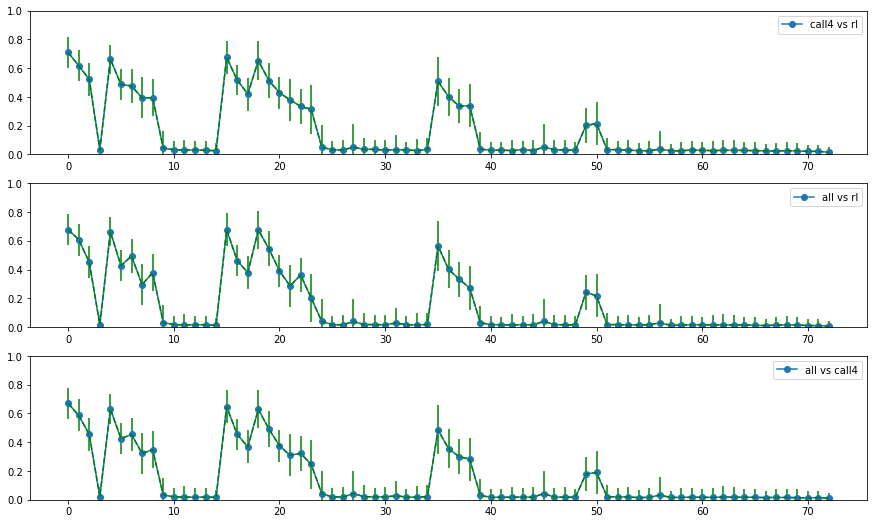

In [37]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.mean(correlations[cell1][cell2][:,:], axis=0)
        y_error = np.std(correlations['mit'][cell][:,:], axis=0)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0, 1])
        ax.legend()
plt.show()

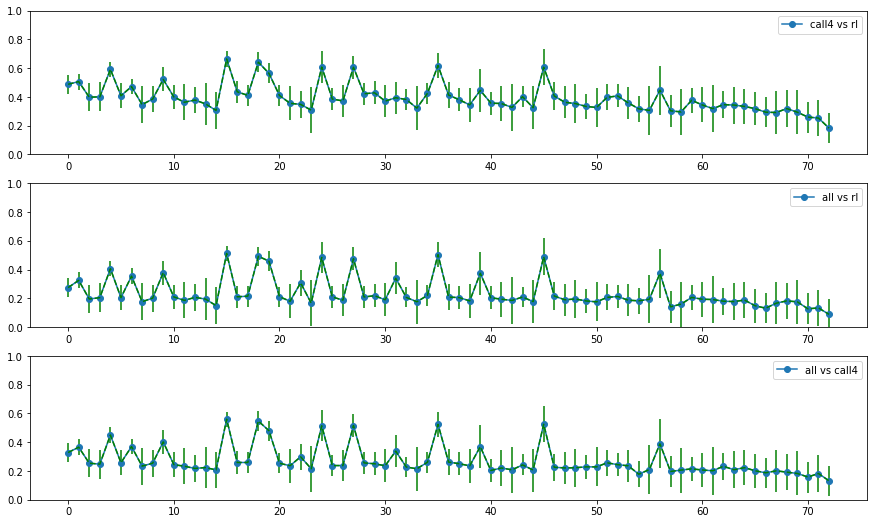

In [86]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.mean(correlations[cell1][cell2][sameIndices,:], axis=0)
        y_error = np.std(correlations['mit'][cell][sameIndices,:], axis=0)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0, 1])
        ax.legend()
plt.show()

# MIC Analysis

In [39]:
raw_weights = np.array([2, 4, 3, 9, 6, 10, 12, 4,
               24, 4, 10, 7, 6, 6, 28, 8,
               14, 8, 5, 12, 9, 11, 32, 15,
               12, 8, 22, 5, 9, 14, 11,
               16, 18, 15, 45, 7, 9, 20,
               13, 8, 20, 11, 15, 36, 15,
               7, 9, 13, 22, 36, 28, 22,
               10, 26, 36, 30, 8, 33, 15,
               22, 26, 15, 12, 28, 26, 12,
               26, 30, 56, 15, 28, 45, 50])
raw_numbers = np.array([2, 2, 1, 3, 2, 2, 3, 1,
               4, 1, 2, 1, 2, 2, 4, 2,
               2, 1, 1, 2, 1, 1, 4, 1,
               2, 1, 2, 1, 1, 2, 1,
               2, 2, 1, 5, 1, 1, 2,
               1, 1, 2, 1, 1, 4, 1,
               1, 1, 1, 2, 3, 2, 2,
               1, 2, 3, 2, 1, 3, 1,
               2, 2, 1, 1, 2, 2, 1,
               2, 2, 4, 1, 2, 3, 5])
normalized_weights = 1 - np.log(raw_weights / raw_numbers) / np.log(73)

In [191]:
header = "MIT,ALL,RL,call4"
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        for orbit in range(72, 73):
            filename = "data/chr%02d_chr%02d_orbit%02d.csv"%(chr1, chr2, orbit)
            n = 100000000
            for cell in data_names:
                cell = cell.lower()
                n = np.min([graphlets[cell][chr1][chr2][:, orbit].shape[0], n])
            temp = np.zeros((n, len(data_names)))
            count = 0
            for cell in data_names:
                cell = cell.lower()
                temp[:, count] = graphlets[cell][chr1][chr2][:n, orbit]
                count += 1
            np.savetxt(filename, temp, delimiter=',', header=header)

In [193]:
#for chr1 in range(1, 24):
#    for chr2 in range(chr1, 24):
#        for orbit in range(73):
#            file_name = "data/chr%02d_chr%02d_orbit%02d.csv"%(chr1, chr2, orbit)
#            command = "java -jar mine.jar %s -allPairs"%file_name
#            print(command)
#            os.system(command)

In [201]:
cells = ['mit', 'all', 'rl', 'call4']
chr2count = {}
count2chr = {}
count = 0
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        chr2count[(chr1, chr2)] = count
        count2chr[count] = (chr1, chr2)
        count += 1
        
mics = {}
for cell in cells:
    mics[cell] = {}
    
for cell1 in cells:
    for cell2 in cells:
        if cell2 <= cell1:
            continue
        mics[cell1][cell2] = np.zeros((count, 73))
        mics[cell2][cell1] = mics[cell1][cell2]
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
#for cell1 in cells:
#    for cell2 in cells:
#        if cell2 <= cell1:
#            continue
#        print(cell1, cell2)
#        count = 0 
#        for chr1 in range(1, 24):
#            for chr2 in range(chr1, 24):
#                mics[cell1][cell2][count, :] =  row_wise_pearson(graphlets[cell1][chr1][chr2].T\
#                                , graphlets[cell2][chr1][chr2].T)
#                count+=1
import string
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        for orbit in range(73):
            filename = "data/chr%02d_chr%02d_orbit%02d.csv,allpairs,cv=0.0,B=n^0.6,Results.csv"\
            %(chr1, chr2, orbit)
            print(filename)
            csvfile = open(filename, 'r')
            csvfile.readline()
            for line in csvfile:
                splitted = line.split(',')
                a = string.replace(splitted[0], "# ", "").lower()
                b = string.replace(splitted[1], "# ", "").lower()
                c = float(splitted[2])
                #print(a, b, c)
                mics[a][b][chr2count[(chr1, chr2)], orbit] = c

data/chr01_chr01_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr01_orbit15.

data/chr01_chr03_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr03_orbit28.

data/chr01_chr05_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr05_orbit35.

data/chr01_chr07_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr07_orbit39.

data/chr01_chr09_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr09_orbit56.

data/chr01_chr11_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr11_orbit69.

data/chr01_chr13_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr13_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr14_orbit07.

data/chr01_chr16_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr16_orbit21.

data/chr01_chr18_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr18_orbit36.

data/chr01_chr20_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr01_chr20_orbit56.

data/chr02_chr02_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr02_orbit40.

data/chr02_chr04_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr04_orbit39.

data/chr02_chr07_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr07_orbit32.

data/chr02_chr10_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr10_orbit36.

data/chr02_chr13_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr13_orbit24.

data/chr02_chr15_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr15_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr15_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr15_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr15_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr16_orbit10.

data/chr02_chr18_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr18_orbit72.

data/chr02_chr21_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr02_chr21_orbit61.

data/chr03_chr03_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr03_orbit40.

data/chr03_chr05_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr05_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr06_orbit13.

data/chr03_chr08_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr08_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr09_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr09_orbit01.

data/chr03_chr11_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr11_orbit65.

data/chr03_chr14_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr14_orbit45.

data/chr03_chr17_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr17_orbit31.

data/chr03_chr20_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr20_orbit18.

data/chr03_chr22_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr03_chr22_orbit66.

data/chr04_chr05_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr05_orbit39.

data/chr04_chr08_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr08_orbit23.

data/chr04_chr10_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr10_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr11_orbit13.

data/chr04_chr13_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr13_orbit62.

data/chr04_chr16_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr16_orbit50.

data/chr04_chr19_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr19_orbit40.

data/chr04_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr04_chr22_orbit22.

data/chr05_chr05_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr05_orbit65.

data/chr05_chr08_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr08_orbit57.

data/chr05_chr11_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr11_orbit44.

data/chr05_chr14_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr14_orbit38.

data/chr05_chr17_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr17_orbit35.

data/chr05_chr20_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr20_orbit23.

data/chr05_chr22_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr22_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr22_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr05_chr23_orbit12.

data/chr06_chr07_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr07_orbit68.

data/chr06_chr10_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr10_orbit50.

data/chr06_chr13_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr13_orbit35.

data/chr06_chr16_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr16_orbit22.

data/chr06_chr18_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr18_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr18_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr18_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr18_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr18_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr19_orbit09.

data/chr06_chr21_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr06_chr21_orbit70.

data/chr07_chr07_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr07_orbit61.

data/chr07_chr10_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr10_orbit23.

data/chr07_chr12_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr12_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr12_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr12_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr12_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr12_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr12_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr13_orbit08.

data/chr07_chr15_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr15_orbit63.

data/chr07_chr18_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr18_orbit47.

data/chr07_chr21_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr21_orbit29.

data/chr07_chr23_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr23_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr23_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr07_chr23_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr08_orbit11.

data/chr08_chr10_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr10_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr11_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr11_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr11_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr11_orbit03.

data/chr08_chr13_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr13_orbit69.

data/chr08_chr16_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr16_orbit50.

data/chr08_chr19_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr19_orbit39.

data/chr08_chr22_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr08_chr22_orbit30.

data/chr09_chr10_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr10_orbit17.

data/chr09_chr12_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr12_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr13_orbit00.

data/chr09_chr15_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr15_orbit50.

data/chr09_chr18_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr18_orbit23.

data/chr09_chr20_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr20_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr21_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr21_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr21_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr21_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr21_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr21_orbit05.

data/chr09_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr09_chr23_orbit57.

data/chr10_chr12_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr12_orbit30.

data/chr10_chr14_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr14_orbit71.

data/chr10_chr17_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr17_orbit45.

data/chr10_chr20_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr20_orbit15.

data/chr10_chr22_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr10_chr22_orbit17.

data/chr11_chr11_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr11_orbit50.

data/chr11_chr13_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr13_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr13_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr13_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr13_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr13_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr14_orbit09.

data/chr11_chr16_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr16_orbit70.

data/chr11_chr19_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr19_orbit26.

data/chr11_chr21_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr21_orbit55.

data/chr11_chr23_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr23_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr11_chr23_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr12_orbit12.

data/chr12_chr14_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr14_orbit15.

data/chr12_chr16_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr16_orbit66.

data/chr12_chr19_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr19_orbit52.

data/chr12_chr22_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr12_chr22_orbit33.

data/chr13_chr14_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr14_orbit23.

data/chr13_chr16_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr16_orbit54.

data/chr13_chr19_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr19_orbit34.

data/chr13_chr22_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr13_chr22_orbit17.

data/chr14_chr14_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr15_orbit14.

data/chr14_chr17_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr17_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr18_orbit06.

data/chr14_chr20_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr20_orbit69.

data/chr14_chr23_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr14_chr23_orbit54.

data/chr15_chr17_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr17_orbit39.

data/chr15_chr20_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr20_orbit33.

data/chr15_chr23_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr15_chr23_orbit16.

data/chr16_chr17_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr17_orbit57.

data/chr16_chr20_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr20_orbit34.

data/chr16_chr22_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr22_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr22_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr22_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr22_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr22_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr16_chr23_orbit09.

data/chr17_chr18_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr18_orbit43.

data/chr17_chr20_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr20_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr20_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr20_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit00.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit01.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit02.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr21_orbit11.

data/chr17_chr23_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit49.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit50.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit51.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit52.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr17_chr23_orbit57.

data/chr18_chr20_orbit03.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit04.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit05.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit06.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit07.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit08.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit09.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit10.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit11.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit12.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr20_orbit18.

data/chr18_chr22_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr22_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr18_chr23_orbit00.

data/chr19_chr20_orbit34.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit35.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit36.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit37.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit38.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit39.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit40.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit41.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit42.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit43.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit44.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit45.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit46.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit47.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit48.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr20_orbit49.

data/chr19_chr23_orbit13.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit14.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit15.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit16.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit17.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit18.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr19_chr23_orbit28.

data/chr20_chr21_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit68.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit69.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit70.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit71.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr21_orbit72.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr20_chr22_orbit00.

data/chr21_chr21_orbit53.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit54.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit55.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit56.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit57.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit58.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit59.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit60.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit61.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit62.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit63.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit64.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit65.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit66.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit67.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr21_chr21_orbit68.

data/chr22_chr22_orbit19.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit20.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit21.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit22.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit23.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit24.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit25.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit26.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit27.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit28.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit29.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit30.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit31.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit32.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit33.csv,allpairs,cv=0.0,B=n^0.6,Results.csv
data/chr22_chr22_orbit34.

(276, 73)


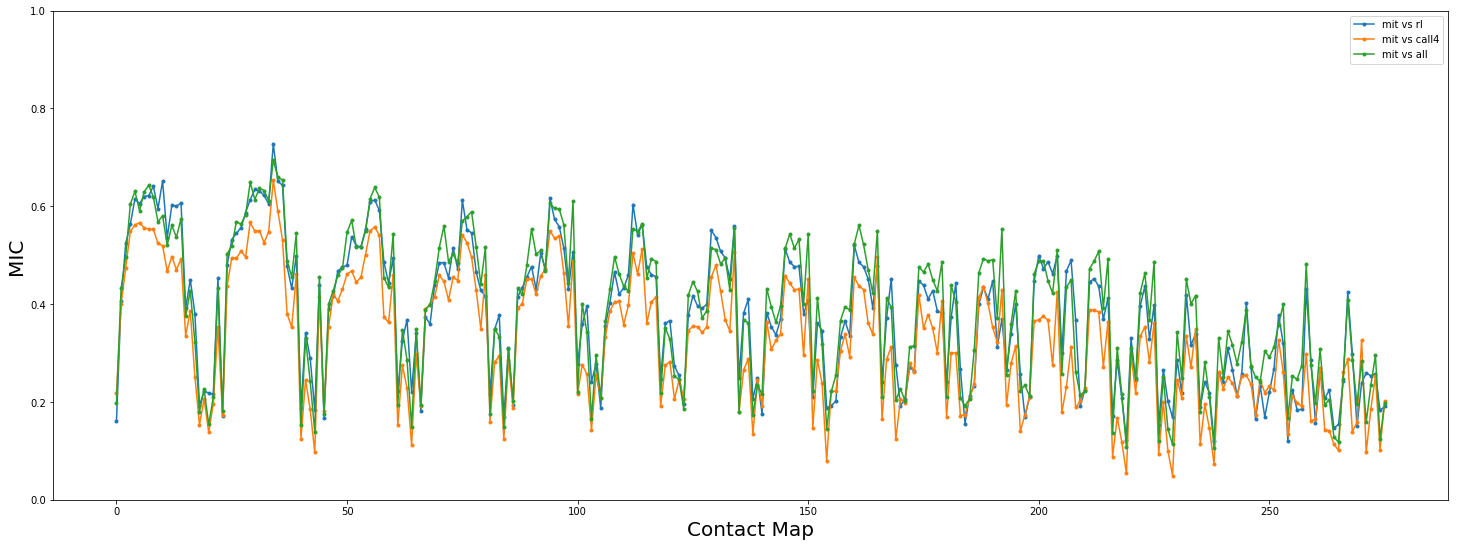

In [206]:
print(mics['mit']['rl'].shape)
pylab.rcParams['figure.figsize'] = (25, 9)
x = range(len(mics['mit']['rl']))
ax = plt.subplot(1, 1, 1)
for cell in mics['mit']:
    y = np.nanmean(mics['mit'][cell][:,indices], axis=1)
    ax.plot(x, y, marker=".", label="mit vs %s"%cell)
    ax.set_ylim([0, 1])
    ax.set_xlabel("Contact Map", fontsize=20)
    ax.set_ylabel("MIC", fontsize=20)
plt.legend()
plt.show()

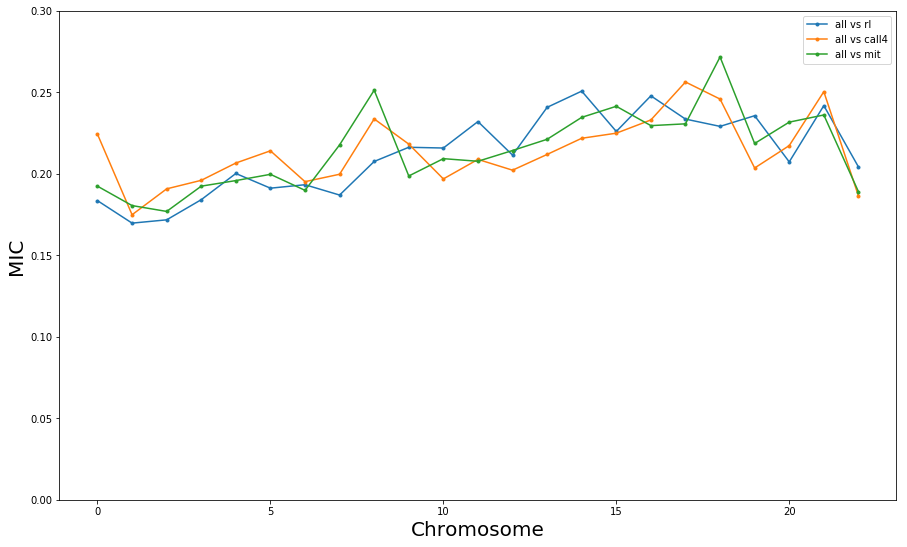

In [217]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
chosen_cell = 'all'
for cell in mics[chosen_cell]:
    y = np.nanmean(mics[chosen_cell][cell][sameIndices,:], axis=1)
    ax.plot(x, y, marker=".", label="%s vs %s"%(chosen_cell, cell))
    ax.set(ylim=[0, .3])
    ax.set_xlabel('Chromosome', fontsize=20)
    ax.set_ylabel('MIC', fontsize=20)
plt.legend()
plt.show()

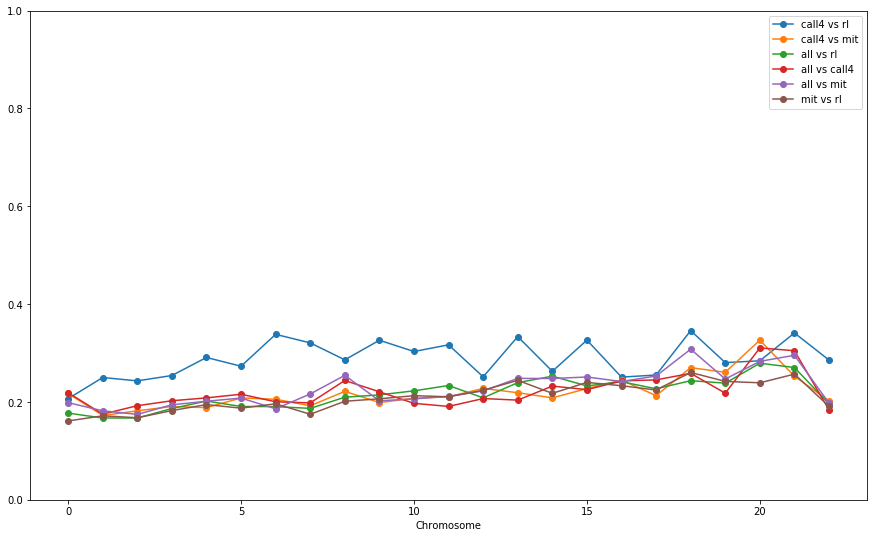

In [209]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(len(sameIndices))
ax = plt.subplot(1, 1, 1)
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.nanmean(mics[cell1][cell2][sameIndices, :][:, indices], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

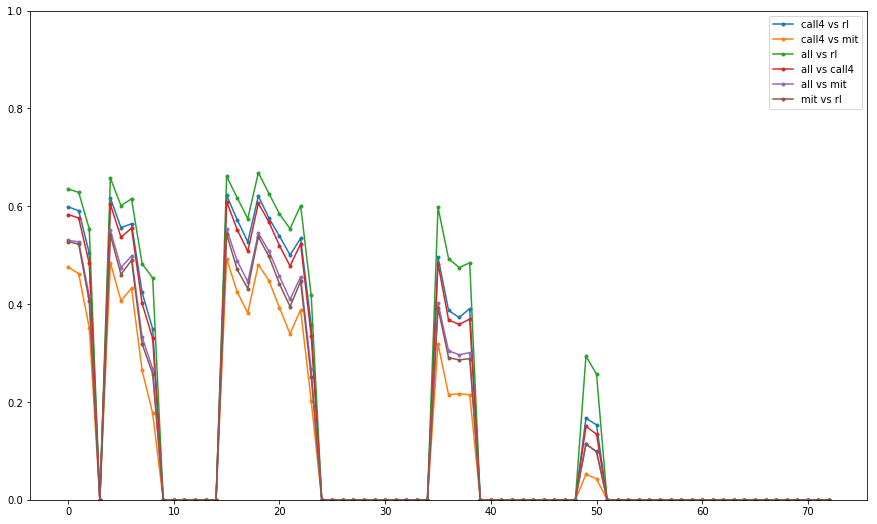

In [230]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(mics[cell1][cell2][differentIndices,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

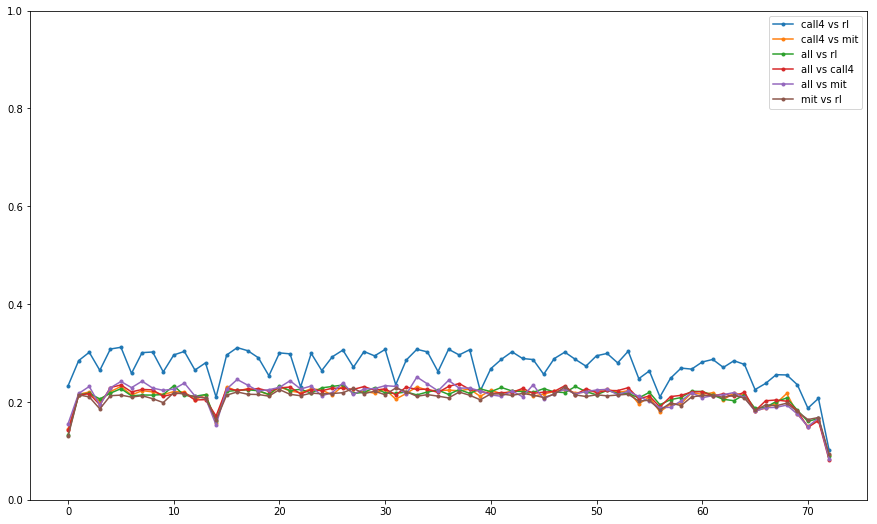

In [228]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in mics:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(mics[cell1][cell2][sameIndices,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

## MIC statsitical analysis

### Comparison between contact maps

In [331]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = mics[cell1][cell2][cmi]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        one_array = np.ones_like(cm)               
        a.append(one_array)
        labels.append("one")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1      mit-rl  <     all-rl  <    all-mit  <  call4-mit  =   call4-rl  <  all-call4  <        one
 1  2      mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 1  3   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  4      mit-rl  =  call4-mit  <    all-mit  =     all-rl  =  all-call4  <   call4-rl  <        one
 1  5   call4-mit  <     mit-rl  <    all-mit  =  all-call4  =   call4-rl  <     all-rl  <        one
 1  6     all-mit  =  call4-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  7   call4-mit  <     mit-rl  =    all-mit  =  all-call4  <     all-rl  =   call4-rl  <        one
 1  8   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  9   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1 10   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     a

 6 11   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 12   call4-mit  <    all-mit  <     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 13   call4-mit  <    all-mit  =     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 14   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  =   call4-rl  <        one
 6 15   call4-mit  <     mit-rl  =    all-mit  <  all-call4  =   call4-rl  <     all-rl  <        one
 6 16   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 17   call4-mit  <     mit-rl  <    all-mit  <  all-call4  =   call4-rl  <     all-rl  <        one
 6 18   call4-mit  <     mit-rl  <    all-mit  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 19   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 20   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     a

utility.py:680: RuntimeWarning: divide by zero encountered in double_scalars
  t = avg / sd * np.sqrt(m*n)


12 20      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 21      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 22      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 23      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 13      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 14      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 15      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 16      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 17      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 18      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   cal

### Comparison between contact maps only considering non-zero orbits

In [332]:
for chr1 in range(1, 24):
    for chr2 in range(chr1, 24):
        cmi = chr2count[(chr1, chr2)]
        a = []
        labels = []
        for cell1 in data_names:
            cell1 = cell1.lower()
            for cell2 in data_names:
                cell2 = cell2.lower()
                if cell2 <= cell1:
                    continue
                cm = mics[cell1][cell2][cmi][indices]
                a.append(cm)
                labels.append("%s-%s"%(cell1, cell2))
        one_array = np.ones_like(cm)               
        a.append(one_array)
        labels.append("one")
        out, text = compare_pairwise(a, labels=labels)
        print("%2d %2d %s"%(chr1, chr2, text))

 1  1      mit-rl  <     all-rl  <    all-mit  =  all-call4  =  call4-mit  =   call4-rl  <        one
 1  2      mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 1  3   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  4      mit-rl  =  call4-mit  <    all-mit  =     all-rl  =  all-call4  <   call4-rl  <        one
 1  5   call4-mit  <     mit-rl  <    all-mit  =  all-call4  =   call4-rl  <     all-rl  <        one
 1  6     all-mit  =  call4-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  7   call4-mit  <     mit-rl  =    all-mit  =  all-call4  <     all-rl  =   call4-rl  <        one
 1  8   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1  9   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 1 10   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     a

 6  8      mit-rl  =  call4-mit  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 6  9   call4-mit  <     mit-rl  <    all-mit  <     all-rl  =  all-call4  =   call4-rl  <        one
 6 10      mit-rl  =  call4-mit  <    all-mit  =  all-call4  <     all-rl  =   call4-rl  <        one
 6 11   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 12   call4-mit  <    all-mit  <     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 13   call4-mit  <    all-mit  =     mit-rl  =  all-call4  =   call4-rl  <     all-rl  <        one
 6 14   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <     all-rl  =   call4-rl  <        one
 6 15   call4-mit  <     mit-rl  =    all-mit  <  all-call4  =   call4-rl  <     all-rl  <        one
 6 16   call4-mit  <    all-mit  <     mit-rl  <  all-call4  <   call4-rl  <     all-rl  <        one
 6 17   call4-mit  <     mit-rl  <    all-mit  <  all-call4  =   call4-rl  <     a

12 22      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
12 23      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 13      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 14      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 15      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 16      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 17      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 18      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 19      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
13 20      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   cal

### Comparison between orbits

In [327]:
for o in range(73):
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = mics[cell1][cell2][:, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    one_array = np.ones_like(cm)               
    a.append(one_array)
    labels.append("one")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 2   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 3      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 4   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 5   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 7   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 8   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 9      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
10      mi

### Comparison between orbits only for intra-chromosomal contact maps

In [325]:
for o in range(73):
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = mics[cell1][cell2][sameIndices, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    one_array = np.ones_like(cm)               
    a.append(one_array)
    labels.append("one")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 1      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 2      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 3      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 4      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 5      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 6      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  =   call4-rl  <        one
 7      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 8      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
 9      mit-rl  =    all-mit  =     all-rl  =  all-call4  =  call4-mit  <   call4-rl  <        one
10      mi

### Comparison between orbits only for non-zero orbits

In [328]:
for o in indices:
    a = []
    labels = []
    for cell1 in data_names:
        cell1 = cell1.lower()
        for cell2 in data_names:
            cell2 = cell2.lower()
            if cell2 <= cell1:
                continue
            cm = mics[cell1][cell2][:, o]
            a.append(cm)
            labels.append("%s-%s"%(cell1, cell2))
    one_array = np.ones_like(cm)               
    a.append(one_array)
    labels.append("one")
    out, text = compare_pairwise(a, labels=labels)
    print("%2d %s"%(o, text))

 0   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 1   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 2   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 4   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 5   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 6   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 7   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
 8   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
15   call4-mit  <     mit-rl  =    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
16   call4-mit  <     mit-rl  <    all-mit  <  all-call4  <   call4-rl  <     all-rl  <        one
17   call4

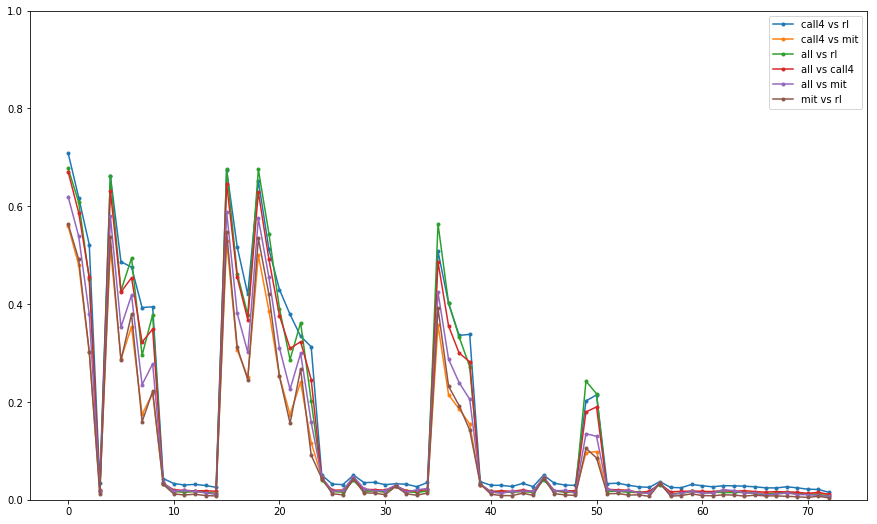

In [227]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    for cell2 in mics[cell1]:
        if cell1 > cell2:
            continue
        y = np.mean(correlations[cell1][cell2][:,:], axis=0)
        ax.plot(x, y, marker=".", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

In [272]:
def compare(a, b):
    if a < b:
        return -1
    if a > b:
        return 1
    return 0
a = [5*np.random.rand(3, 4)-.6, np.random.rand(3, 4)*5]
compare_pairwise(a, labels=['a', 'b'])

(array([[0., 0.],
        [0., 0.]]), ' a = b')